# Car License Plate OCR

In this notebook, I use a Tensorflow model from Tensorflow Model Garden to detect car license plates in image data from a Kaggle dataset containing about 430 images of car license plates accompanied by XML files containing bounding box labels. Then I extract images of the ROI containing the license plates, use a super-resolution GAN to enhance the image of the ROI, and easyocr to read the text on the license plate.

Automatic license plate detection and OCR could be implemented on red-light cameras and toll-booth cameras. I'm not saying I want people getting tickets for 1 foot of the back of their car being in the intersection right when the light turns red, I'm just saying this is one way some jerk could enforce that.

In [11]:
import os

import tarfile
import urllib.request

import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format
from object_detection.builders import model_builder
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
import tensorflow_hub as hub

import easyocr

import re
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import math
from string import ascii_uppercase

%matplotlib inline

import pytesseract

## Creating TFRecord Data

First, we need to train the license plate recognition model. I'll use a model from Tensorflow Model Garden, but I still have to train it for this specific task, and so I'll need to create TFRecord data.

In [12]:
DATA_ROOT_DIR = os.path.join('C:\\', '_local', 'data_sets', 'image', 'car_plates')
TRAIN_DIR = os.path.join(DATA_ROOT_DIR, 'train') # Location of training images and XML lables
TEST_DIR = os.path.join(DATA_ROOT_DIR, 'test') # Location of testing images and XML labels

# Our initial model only looks for 1 thing: license plates
labels = [{'name': 'licence', 'id': 1}]

LABEL_MAP_PATH = os.path.join(DATA_ROOT_DIR, 'label_map.pbtxt')
with open(LABEL_MAP_PATH, 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

In [13]:
# Code for converting data in TFRecord format if no TFRecords in data directory

GENERATE_TF_RECORD_SCRIPT_PATH = os.path.join(DATA_ROOT_DIR, 'generate_tfrecord.py')
TF_RECORD_TRAIN_PATH = os.path.join(DATA_ROOT_DIR, 'train.record')
TF_RECORD_TEST_PATH = os.path.join(DATA_ROOT_DIR, 'test.record')

if not os.path.exists(TF_RECORD_TRAIN_PATH):
    !python {GENERATE_TF_RECORD_SCRIPT_PATH} -x{TRAIN_DIR} -l{LABEL_MAP_PATH} -o{TF_RECORD_TRAIN_PATH} -i{TRAIN_DIR}
    
if not os.path.exists(TF_RECORD_TEST_PATH):
    !python {GENERATE_TF_RECORD_SCRIPT_PATH} -x{TEST_DIR} -l{LABEL_MAP_PATH} -o{TF_RECORD_TEST_PATH} -i{TEST_DIR}

## Downloading Model

In [14]:
# TF_OD_MODELS_ROOT_DIR is the directory containing the object detection models from Tensorflow Model Garden
TF_OD_MODELS_ROOT_DIR =  os.path.join('C:\\', '_local', 'py', 'tensorflow', 'models', 'research', 'object_detection')
TF_MODELS_DIR = os.path.join(TF_OD_MODELS_ROOT_DIR, 'downloaded_models')
TF_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
TF_MODEL_PATH = os.path.join(TF_MODELS_DIR, TF_MODEL_NAME)

if not os.path.exists(TF_MODEL_PATH):
    os.mkdir(TF_MODEL_PATH)
    
TF_MODEL_TAR_FILENAME = TF_MODEL_NAME + '.tar.gz'
TF_MODEL_TAR_PATH = os.path.join(TF_MODEL_PATH, TF_MODEL_TAR_FILENAME)
TF_MODEL_CKPT_PATH = os.path.join(TF_MODEL_PATH, 'checkpoint')
TF_MODEL_CFG_PATH = os.path.join(TF_MODEL_PATH, 'pipeline.config')
    
TF_MODELS_DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/tf2/'
TF_MODEL_DATE = '20200711'
TF_MODEL_DOWNLOAD_LINK = TF_MODELS_DOWNLOAD_BASE + TF_MODEL_DATE + '/' + TF_MODEL_TAR_FILENAME

# Download desired model if not already downloaded
if not os.path.exists(TF_MODEL_CKPT_PATH):
    print('Downloading model. This may take a while... ', end='')
    urllib.request.urlretrieve(TF_MODEL_DOWNLOAD_LINK, TF_MODEL_TAR_PATH)
    tar_file = tarfile.open(TF_MODEL_TAR_PATH)
    tar_file.extractall(TF_MODELS_DIR)
    tar_file.close()
    os.remove(TF_MODEL_TAR_PATH)
    print('Done')
else:
    print('You already have the desired model')

You already have the desired model


## Training Model

In [15]:
PROJECT_ROOT_DIR = os.path.join('C:\\', '_local', 'py', 'car_plate_ocr')

# Root directory for this project's trained model
PROJECT_MODEL_ROOT_DIR = os.path.join(PROJECT_ROOT_DIR, TF_MODEL_NAME) 
if not os.path.exists(PROJECT_MODEL_ROOT_DIR):
    os.mkdir(PROJECT_MODEL_DIR)

# Directory for this project's model pipeline config
# Will initially be copy of Model Garden config, but we will change
PROJECT_MODEL_CFG_PATH = os.path.join(PROJECT_MODEL_ROOT_DIR, 'pipeline.config')
if not os.path.exists(PROJECT_MODEL_CFG_PATH):
    !copy {TF_MODEL_CFG_PATH} {PROJECT_MODEL_ROOT_DIR}

In [16]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(PROJECT_MODEL_CFG_PATH, "r") as f:
    proto_str = f.read()  
    text_format.Merge(proto_str, pipeline_config)  
    
model_config = config_util.get_configs_from_pipeline_file(PROJECT_MODEL_CFG_PATH)

In [17]:
# Path to initial checkpoint in Model Garden
FINE_TUNE_CKPT_PATH = os.path.join(TF_MODEL_CKPT_PATH, 'ckpt-0')

# Directory of this project's model checkpoints
PROJECT_MODEL_CKPTS_DIR = os.path.join(PROJECT_MODEL_ROOT_DIR, 'checkpoints')
if not os.path.exists(PROJECT_MODEL_CKPTS_DIR):
    os.mkdir(PROJECT_MODEL_CKPTS_DIR)

# If we have checkpoints saved in this project's checkpoint directory from previous training sessions,
# then this code finds the most recent checkpoint and sets that as the initial checkpoint for the next training session
current_ckpt_num = 0
for f in os.listdir(PROJECT_MODEL_CKPTS_DIR):
    search = re.search('ckpt-\d+', f)
    if search:
        ckpt_num = ''.join([s for s in search.group() if s.isdigit()])
        ckpt_num = int(ckpt_num)
        
        if ckpt_num > current_ckpt_num:
            current_ckpt_num = ckpt_num
            FINE_TUNE_CKPT_PATH = os.path.join(PROJECT_MODEL_CKPTS_DIR, search.group())
            
print(f'path of initial training checkpoint:\n{FINE_TUNE_CKPT_PATH}')

# Pipeline config customization for this project
pipeline_config.model.ssd.num_classes = len(labels) # How many things our model is detecting
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = FINE_TUNE_CKPT_PATH # Initial training checkpoint
pipeline_config.train_config.fine_tune_checkpoint_type = 'detection'
pipeline_config.train_input_reader.label_map_path = LABEL_MAP_PATH
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [TF_RECORD_TRAIN_PATH]
pipeline_config.eval_input_reader[0].label_map_path = LABEL_MAP_PATH
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [TF_RECORD_TEST_PATH]

path of initial training checkpoint:
C:\_local\py\car_plate_ocr\ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8\checkpoints\ckpt-28


In [18]:
# Get config for next training session
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(PROJECT_MODEL_CFG_PATH, 'wb') as f:
    f.write(config_text)

In [19]:
# Get command for training
TRAINING_SCRIPT_PATH = os.path.join(TF_OD_MODELS_ROOT_DIR, 'model_main_tf2.py')
cmd = (
    f'python {TRAINING_SCRIPT_PATH}'
    f' --model_dir={PROJECT_MODEL_ROOT_DIR}'
    f' --pipeline_config_path={PROJECT_MODEL_CFG_PATH}'
    f' --num_train_steps=1000'
)
print(cmd)

python C:\_local\py\tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=C:\_local\py\car_plate_ocr\ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8 --pipeline_config_path=C:\_local\py\car_plate_ocr\ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8\pipeline.config --num_train_steps=1000


To train the license plate detection model, we run simply run the above script. I trained my model in 1000-step epochs (the number of steps the model is configured to save checkpoints at) since training can take long due to the size of the detection model. In the rest of this notebook, I am using a model which was trained for about 10 epochs.

The following cell provides code for managing checkpoints. I would like to have all my checkpoints in one place, but the directory that checkpoints are saved in must differ from the directory of the checkpoint that the training is started from. Additionally, the saved checkpoints from a training session are numbered starting from 1 (e.g., after epoch 3, 'ckpt-3' is saved), but since I trained over several sessions, this numbering does not reflect how many epochs the model has been trained for. To work around these things, I configured the model to save the new checkpoints into a different directory than the previous checkpoints, and once a training session is finished, I run the following code which renames the new checkpoints and moves them to my checkpoint directory.

In [20]:
max_ckpt_num = current_ckpt_num
for f in os.listdir(PROJECT_MODEL_ROOT_DIR):
    reg = re.search('ckpt-\d+', f)
    if reg:
        ckpt_num = int(''.join([d for d in reg.group() if d.isdigit()]))
        
        if ckpt_num <= current_ckpt_num:
            ckpt_new_num_str = str(current_ckpt_num + ckpt_num)
            ckpt_new_name = re.sub('ckpt-\d+', f'ckpt-{ckpt_new_num_str}', f)
            
            if max_ckpt_num < current_ckpt_num + ckpt_num:
                max_ckpt_num = current_ckpt_num + ckpt_num
            
        src_path = os.path.join(PROJECT_MODEL_ROOT_DIR, f)
        dst_path = os.path.join(PROJECT_MODEL_CKPTS_DIR, ckpt_new_name)
        print(f'{src_path} --> \n{dst_path}\n')
        
        os.rename(src_path, dst_path)
        
current_ckpt_num = max_ckpt_num

old_ckpt_path = os.path.join(PROJECT_MODEL_CKPTS_DIR, 'checkpoint')
new_ckpt_path = os.path.join(PROJECT_MODEL_ROOT_DIR, 'checkpoint')

if os.path.exists(new_ckpt_path):
    os.replace(new_ckpt_path, old_ckpt_path)
    print(f'the file at {new_ckpt_path} has been moved to \n{old_ckpt_path}')

## Get Sample Output Images

In [21]:
# Get most recent (presumably best performing) model version
configs = config_util.get_configs_from_pipeline_file(PROJECT_MODEL_CFG_PATH)
model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt_name = 'ckpt-16'
ckpt_name = f'ckpt-{current_ckpt_num}'
latest_ckpt_path = os.path.join(PROJECT_MODEL_CKPTS_DIR, ckpt_name)
ckpt = tf.compat.v2.train.Checkpoint(model=model)
ckpt.restore(latest_ckpt_path).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)
    return detections

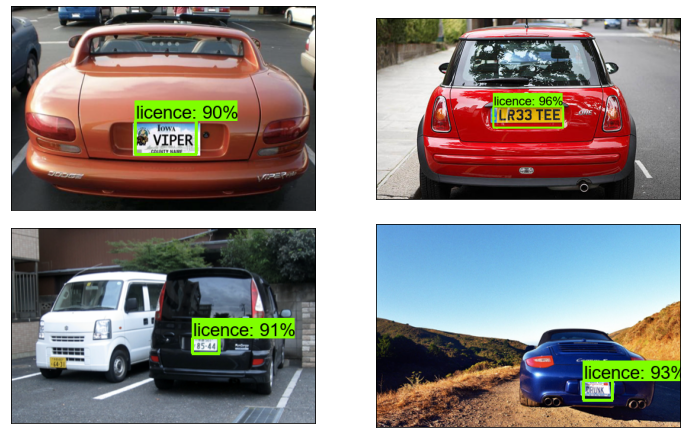

In [55]:
category_index = label_map_util.create_category_index_from_labelmap(LABEL_MAP_PATH)
SAMPLE_IMAGE_PATHS = [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR)[:8] if f.split('.')[-1]=='png']

DETECTION_THRESHOLD = .7
sample_license_detection_boxes = []

# Get detection boxes and draw boxes on images
def get_license_detection_boxes(img_path):
    
    img = cv2.imread(img_path)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor) # Get detections in image

    num_detections = int(detections.pop('num_detections'))
    detections_dict = { key: value[0, :num_detections].numpy() for key, value in detections.items() }
    detections_dict['num_detections'] = num_detections
    
    # Insure detection classes are stored as ints
    detections_dict['detection_classes'] = detections_dict['detection_classes'].astype(np.int64)
    image_np_with_detections = image_np.copy()
        
    # Convert image to RGB
    return cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB), detections_dict

def draw_detection_boxes_on_image(image_np_with_detections, detections_dict, detection_threshold=DETECTION_THRESHOLD):

    img = image_np_with_detections.copy()
    
    # Draw boxes for detections
    viz_utils.visualize_boxes_and_labels_on_image_array(
        img,
        detections_dict['detection_boxes'], detections_dict['detection_classes']+1, detections_dict['detection_scores'], 
        category_index, use_normalized_coordinates=True, 
        max_boxes_to_draw=3, min_score_thresh=detection_threshold, agnostic_mode=False
    )
    
    return img

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
plt.subplots_adjust(hspace=-.5)
for img_path, ax in zip(SAMPLE_IMAGE_PATHS, axs.reshape(-1)):
    
    detection_img, detection_dict = get_license_detection_boxes(img_path)
    sample_license_detection_boxes.append( (detection_img, detection_dict) )
    img = draw_detection_boxes_on_image(detection_img, detection_dict)

    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

## Applying OCR to Sample Output Images

Since our model can identify license plates and their ROIs with reasonable accuracy, now we try applying OCR to the images contained in the bounding boxes using easyocr. I tried using pytesseract, but despite preprocessing, it did not perform as well as easyocr.

In [58]:
easy_ocr_reader = easyocr.Reader(lang_list=['en'], gpu=False)
OCR_ALLOW_LIST = ascii_uppercase + '1234567890 -'

# Use easyocr to extract license plate number
# Assumes license plate number is largest detection easyocr will have
def easyocr_read_roi(roi):
    
    roi_width, roi_height, _ = roi.shape
    
    roi_ocr = easy_ocr_reader.readtext(
        roi, allowlist=OCR_ALLOW_LIST, slope_ths=.4, width_ths=roi_width/roi_height,
    )
    
    # Get areas for each easyocr detection in image / roi
    roi_ocr_areas = [
        # /---- roi width ----/ /---- roi height ---/
        ( (box[1][0]-box[0][0])*(box[2][1]-box[1][1]), string ) for box, string, conf in roi_ocr if len(string) != 0
    ]
    
    # If easyocr did not detect any characters, return ''
    if len(roi_ocr_areas) == 0:
        return ''
    
    # Largest area of easyocr detections
    max_area = max(roi_ocr_areas, key=lambda box_str: box_str[0])[0]
    
    # Concatenate all easyocr detections which have an area of at least 85% of largest area
    ocr_result = ''.join( [string for area, string in roi_ocr_areas if .85*max_area <= area] )
    return ocr_result

# Read each detected license plate in images
def easyocr_read_image(detection_image, detection_dict, detection_threshold=DETECTION_THRESHOLD):
    
    img_height, img_width, img_channels = detection_image.shape
    
    # Get the ROIs for each detection with confidence >= detection_threshold
    high_detection_score_mask = detection_dict['detection_scores'] >= detection_threshold
    high_detection_score_boxes = detection_dict['detection_boxes'][high_detection_score_mask]

    ocr_results = []
    for box in high_detection_score_boxes:
        
        roi = (box * [img_height, img_width, img_height, img_width]).astype(int)
        
        x_slice = slice(roi[0], roi[2])
        y_slice = slice(roi[1], roi[3])
        img = detection_image[x_slice, y_slice]
        
        img_ocr_pair = (img, easyocr_read_roi(img))
        ocr_results.append(img_ocr_pair)
        
    return ocr_results

In [59]:
def plot_ocr_results(ocr_results, figsize):
    
    num_rows_to_plot = math.ceil( len(ocr_results) / 2 )
    fig, axs = plt.subplots(num_rows_to_plot, 2, figsize=figsize)

    for (img_detection, ocr_results), ax in zip(ocr_results, axs.reshape(-1)):

        ax.imshow(img_detection)
        ax.set_title(f'ocr result: {ocr_results}')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

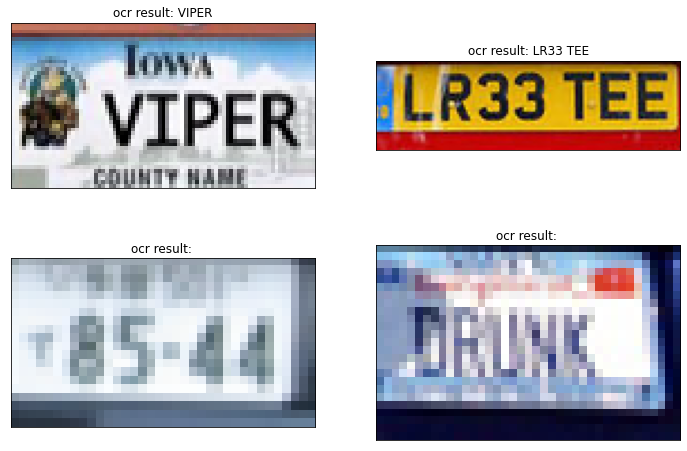

In [60]:
# Get easyocr predictions on raw sample data
sample_data_easyocrs = [easyocr_read_image(*box) for box in sample_license_detection_boxes]
sample_data_easyocrs = np.concatenate([ocr for ocr in sample_data_easyocrs if len(ocr) != 0])

plot_ocr_results(sample_data_easyocrs, (12, 8))

## Resizing and Super-Resolution

Since the images are relatively small, resizing them will probably improve easyocr's performance. Additionally, since the images have low resolutions, we can use an ESRGAN to enhance the resolutions, which will also probably improve easyocr's performance. We could also try combining those 2 approaches, but constructing those images takes a significantly longer time (about 5 minutes for each type of image), and I (spoiler-alert) I found that simply enhancing the ROIs yielded the best performance.

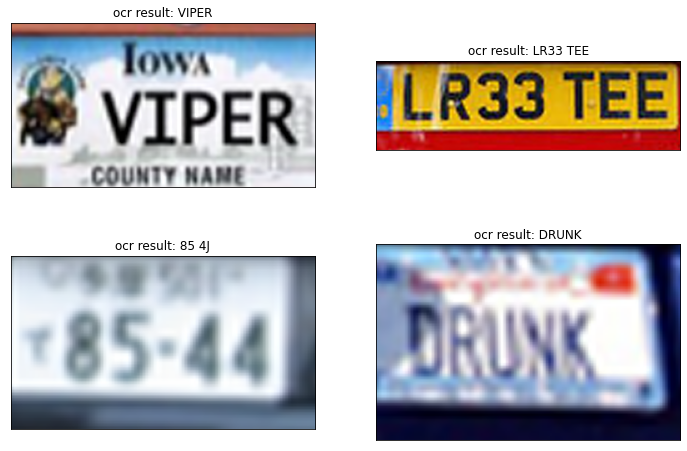

CPU times: total: 9.2 s
Wall time: 2.64 s


In [61]:
%%time
# Get easyocr predictions on sample data resized by 3x

sample_license_detection_boxes_imgs_expanded = [
    ( cv2.resize(img.copy(), None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC), detection_dict )
    for img, detection_dict in sample_license_detection_boxes
]

sample_data_expanded_easyocrs = [easyocr_read_image(*box) for box in sample_license_detection_boxes_imgs_expanded]
sample_data_expanded_easyocrs = np.concatenate([ocr for ocr in sample_data_expanded_easyocrs if len(ocr) != 0])

plot_ocr_results(sample_data_expanded_easyocrs, (12, 8))

In [34]:
# We can load the ESRGAN directly from TF_Hub
# No configuration is necessary since we do not need to train it
super_resolution_gan = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")

# Use super-resolution GAN to enhance image
def enhance_image(img):
    
    processed_img = img.copy().astype('float32')
    
    if len(img.shape) == 3:
        processed_img = np.expand_dims(processed_img, 0)
        
    enhanced_img = super_resolution_gan(processed_img).numpy().squeeze()
    enhanced_img = np.clip(enhanced_img, 0, 255).astype('uint8')
    return enhanced_img

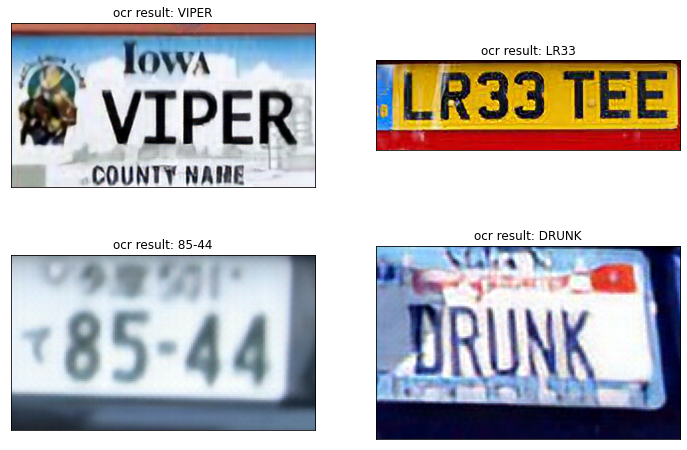

CPU times: total: 5min 43s
Wall time: 56.8 s


In [63]:
%%time
# Sample data performance on enhanced images

sample_license_detection_boxes_imgs_enhanced = [
    (enhance_image(img), detection_dict) for img, detection_dict in sample_license_detection_boxes
]

sample_data_enhanced_easyocrs = [easyocr_read_image(*box) for box in sample_license_detection_boxes_imgs_enhanced]
sample_data_enhanced_easyocrs = np.concatenate([ocr for ocr in sample_data_enhanced_easyocrs if len(ocr) != 0])

plot_ocr_results(sample_data_enhanced_easyocrs, (12, 8))

## Evaluate Test Set Results

We saw that the ROIs which were just enhanced and not expanded produced the best easyocr performance, so we'll evaluate test performance on those. Howwever, because the data does not have labels for the license's vehicle registrations, we'll have to compare the easyocr predictions to the (22 test) images, since I don't feel like adding vehicle registrations for each of the 430 dataset observations. 

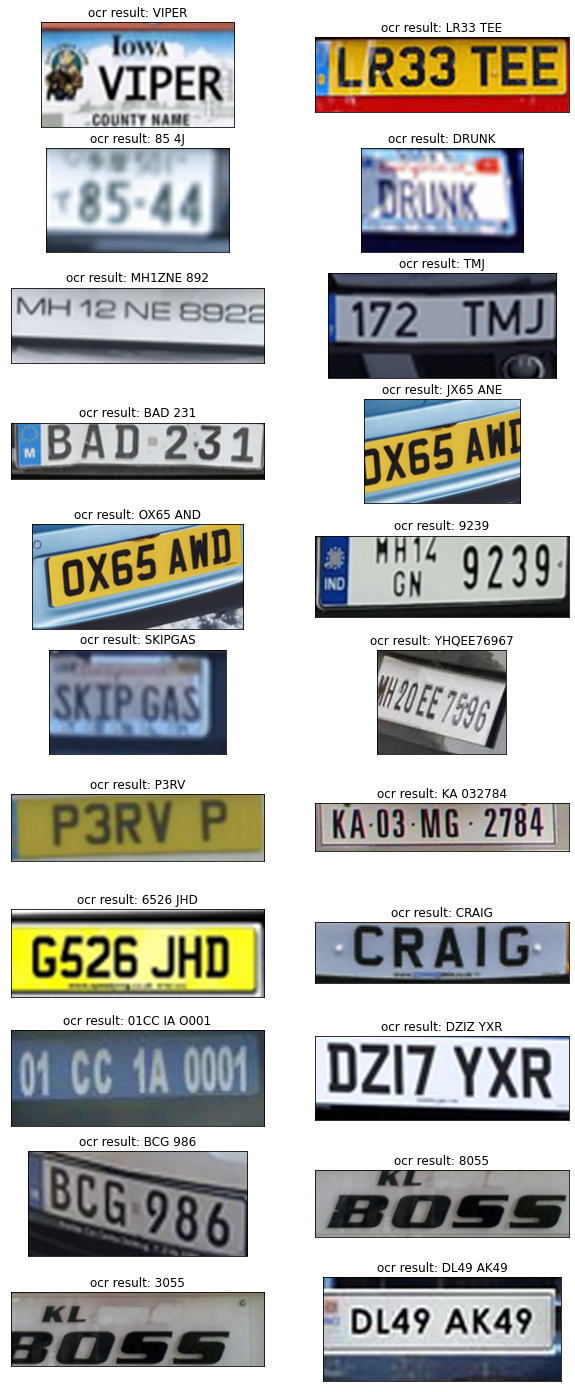

CPU times: total: 37min 26s
Wall time: 6min 7s


In [64]:
%%time

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

TEST_DATA_PATHS = [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR) if f.split('.')[-1] == 'png']
test_data_images_detection_dicts = [get_license_detection_boxes(img_path) for img_path in TEST_DATA_PATHS]

test_images_enhanced = [
    (enhance_image(img), detection_dict) 
    for img, detection_dict in test_data_images_detection_dicts
]

test_data_easyocrs = [easyocr_read_image(*box) for box in test_images_enhanced_expanded]
test_data_easyocrs = np.concatenate([ocr for ocr in test_data_easyocrs if len(ocr) != 0])

plot_ocr_results(test_data_easyocrs, (10, 25))

We find our model does a good job at bounding detected license plates: most of the above images have the entire license plate at or near the center of the image, and include the entire license plate. However, there were about 5 license plates in the testing images that the current model did not detect (one is in the 3rd sample image under the 'Get Sample Output Images' section), but this would likely be solved with more training and potentially more data.

Differences between the OCR readings and actual license plate numbers can be due to easyocr misreading, the low resolution of the images (despite enhancement) due to their small size in the data images, or insufficiently accurate bounding boxes: improving the bounding boxes so that the ROIs just contain the license plates, and thus have homogenous backgrounds, will probably help easyocr.